<a href="https://colab.research.google.com/github/ehadsaloF/Electricity-Demand-Forecasting/blob/main/Electricity_Demand_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler


import warnings
warnings.filterwarnings("ignore")

This dataset contains 4 years of electrical consumption, generation, pricing, and weather data for Spain. 

In [ ]:
df = pd.read_csv('/content/energy2.csv', index_col=['time'])
df.index = pd.to_datetime(df.index, errors='coerce', utc=True)

In [ ]:
df.head()

,total load forecast,total load actual
time,,
2014-12-31 23:00:00+00:00,26118,25385.0
2015-01-01 00:00:00+00:00,24934,24382.0
2015-01-01 01:00:00+00:00,23515,22734.0
2015-01-01 02:00:00+00:00,22642,21286.0
2015-01-01 03:00:00+00:00,21785,20264.0


In [ ]:
df.shape

(35064, 2)

##Data Cleaning

In [ ]:
# check for datatype of features
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35064 entries, 2014-12-31 23:00:00+00:00 to 2018-12-31 22:00:00+00:00
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   total load forecast  35064 non-null  int64  
 1   total load actual    35028 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 821.8 KB


There are 36 missing values for the total load actual column, this will be filled using KNN imputation

In [ ]:
# Make sure the data is sorted in ascending order by date
df = df.sort_index()

# Find the missing values in the data
missing_mask = df['total load actual'].isnull()

# Convert the DataFrame to a NumPy array
data_array = df.values

# Initialize the KNN imputer with k=5
imputer = KNNImputer(n_neighbors=5)

# Perform the imputation
imputed_data_array = imputer.fit_transform(data_array)

# Convert the imputed array back to a DataFrame
imputed_data = pd.DataFrame((imputed_data_array), columns=df.columns, index=df.index)

imputed_data['total load actual'] = imputed_data['total load actual'].apply(lambda x: math.ceil(x))

In [ ]:
imputed_data[missing_mask]

In [ ]:
imputed_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35064 entries, 2014-12-31 23:00:00+00:00 to 2018-12-31 22:00:00+00:00
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   total load forecast  35064 non-null  float64
 1   total load actual    35064 non-null  int64  
dtypes: float64(1), int64(1)
memory usage: 821.8 KB


##Descriptive Statistics

In [ ]:
#descriptive statistics
imputed_data.describe()

,total load forecast,total load actual
count,35064.000000,35064.000000
mean,28712.129962,28697.917380
std,4594.100854,4575.984217
min,18105.000000,18041.000000
25%,24793.750000,24807.000000
50%,28906.000000,28902.500000
75%,32263.250000,32193.000000
max,41390.000000,41015.000000


## Univariate Electricity Demand Forecast

### Decomposition Technique
Time series data is usually composed of four components, a trend component which indicates an increase or decrease in the data over a long period of time, a cyclical component which causes the data to rise and fall over a period of time that is longer than a season, a seasonal component that indicates the data fluctuates regularly around the trend line and a noise component that represents the part of the data that is not accounted for by the other components. 

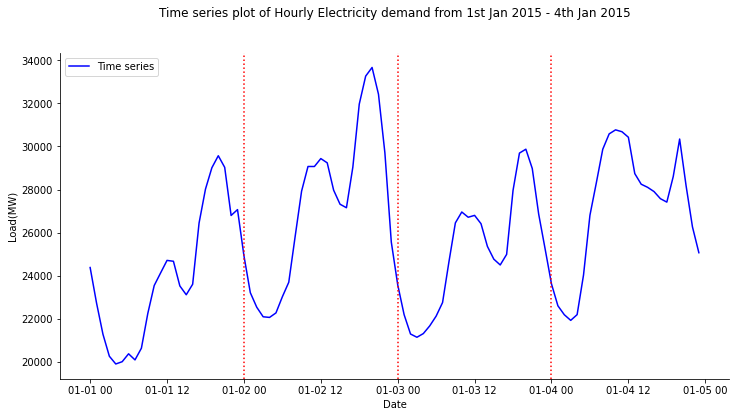

In [ ]:
# create a figure and axis object
fig, ax = plt.subplots(figsize=(12, 6))

#resampling data 
daily_dem = imputed_data.resample('H').mean()

# define the start and end dates for the plot
start_date = '2015-01-01 00:00:00+00:00'
end_date = '2015-01-04 23:00:00+00:00'

# subset the data to include only the desired date range
subset_data = daily_dem.loc[start_date:end_date]

# plot the time series data
ax.plot(subset_data.index, subset_data['total load actual'], color='blue', label='Time series')

# insert lines at certain dates
line_dates = pd.to_datetime(['2015-01-02 00','2015-01-03 00', '2015-01-04 00'])
for date in line_dates:
    ax.axvline(x=date, color='red', linestyle=':')

# customize the plot
ax.set_xlabel('Date')
ax.set_ylabel('Load(MW)')
ax.set_title('Time series plot of Hourly Electricity demand from 1st Jan 2015 - 4th Jan 2015\n\n')
ax.legend(loc='upper left')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# show the plot
plt.show()


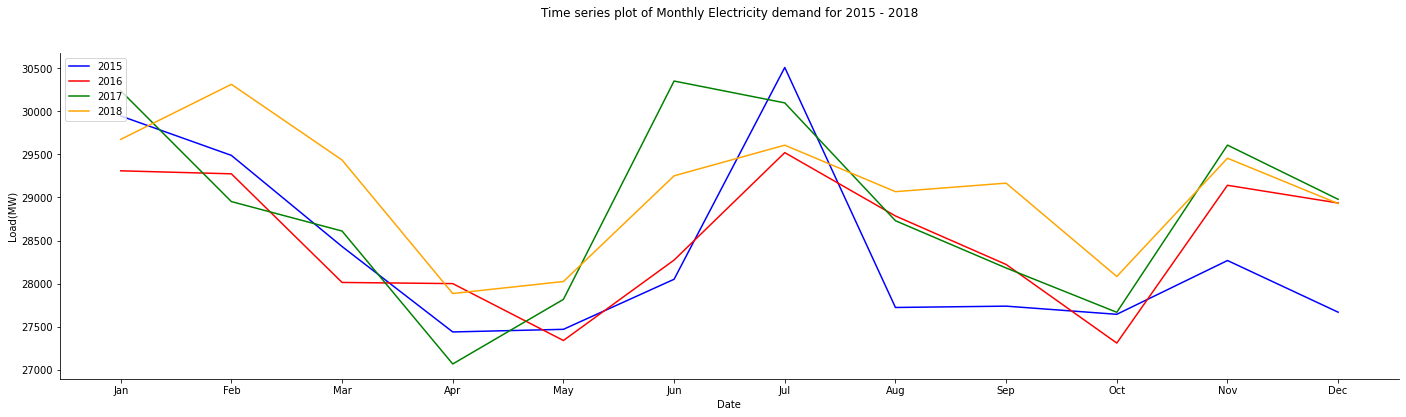

In [ ]:
# create a figure and axis object
fig, ax = plt.subplots(figsize=(24, 6))

#resampling data by month
monthly_dem = imputed_data.resample('M').mean()

# Extract year data and the year from the index
dem_2015 = monthly_dem.loc['2015-01': '2015-12']
dem_2015.index = dem_2015.index.strftime('%m')

dem_2016 = monthly_dem.loc['2016-01': '2016-12']
dem_2016.index = dem_2016.index.strftime('%m')

dem_2017 = monthly_dem.loc['2017-01': '2017-12']
dem_2017.index = dem_2017.index.strftime('%m')

dem_2018 = monthly_dem.loc['2018-01': '2018-12']
dem_2018.index = dem_2018.index.strftime('%m')

# plot the time series data
ax.plot(dem_2015.index, dem_2015['total load actual'], color='blue', label='2015')

ax.plot(dem_2016.index, dem_2016['total load actual'], color='red', label='2016')

ax.plot(dem_2017.index, dem_2017['total load actual'], color='green', label='2017')

ax.plot(dem_2018.index, dem_2018['total load actual'], color='orange', label='2018')



# customize the plot

# Set the x-axis tick labels
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

ax.set_xlabel('Date')
ax.set_ylabel('Load(MW)')
ax.set_title('Time series plot of Monthly Electricity demand for 2015 - 2018\n\n')
ax.legend(loc='upper left')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# show the plot
plt.show()


The Graph above is the time series plot of Hourly electricity demand from 1st Jan 2015 - 4th Jan 2015
<p> The plot shows that the data is seasonal, the three vertical lines show a pattern in the data that repeats every 24 Hours, this indicates that the data has 24 seasons. 

 <p>An additive model is appropriate for this data because the seasonal variations are relatively constant over time. 
 <p> In additive decomposition, the time series data, Yt, is a sum of the decomposed components, i.e.,  


> <p> Y(t) = T(t) + S(t) + E(t)












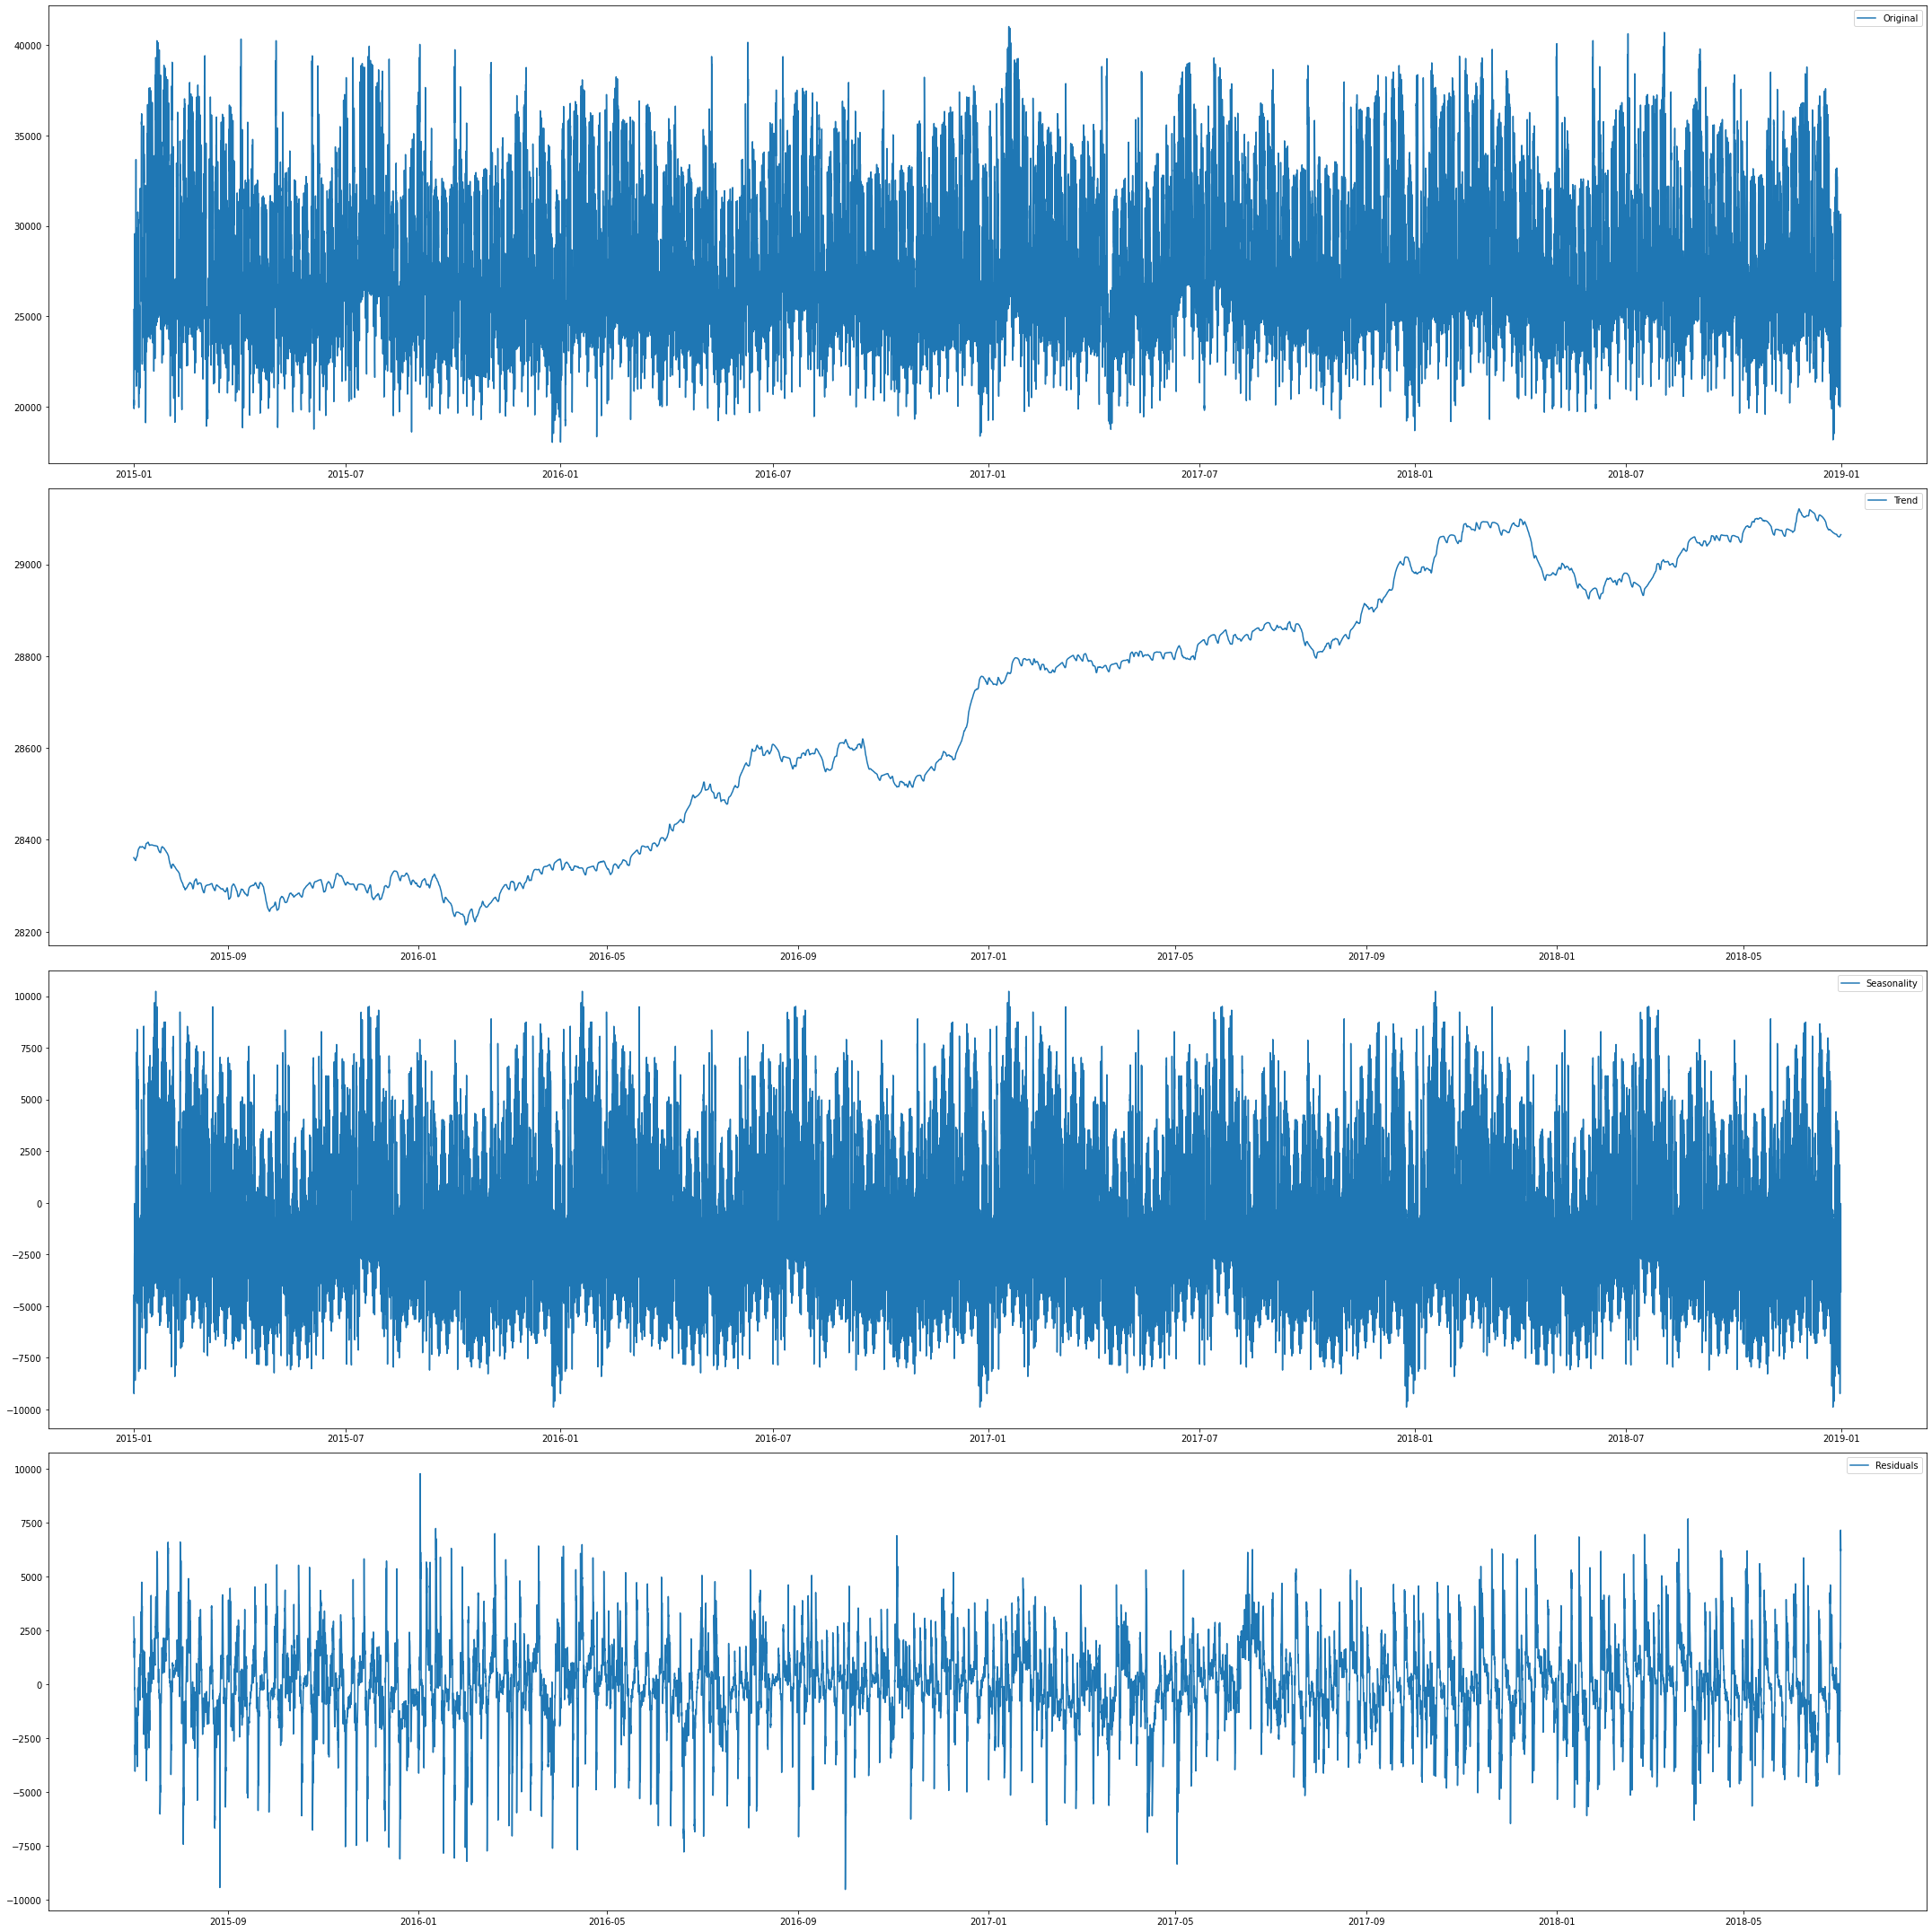

In [ ]:
# perform additive decomposition

decomposition = seasonal_decompose(imputed_data[['total load actual']], model='additive',period=24*365)

# plot the decomposition results


plt.figure(figsize=(30,30))
plt.subplot(411)
plt.plot(imputed_data[['total load actual']], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decomposition.seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decomposition.resid, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()
# ax.legend(loc='best')
# plt.show()



After decomposing the data, we will then train various model on the deseasonalized data

In [ ]:
# Get the deseasonalized data
deseasonalized = imputed_data['total load actual'] - decomposition.seasonal

pd.DataFrame(deseasonalized)

,0
time,
2014-12-31 23:00:00+00:00,29858.487807
2015-01-01 00:00:00+00:00,30553.956472
2015-01-01 01:00:00+00:00,30329.777058
2015-01-01 02:00:00+00:00,29888.601430
2015-01-01 03:00:00+00:00,29409.106358
...,...
2018-12-31 18:00:00+00:00,30690.254360
2018-12-31 19:00:00+00:00,29981.017849
2018-12-31 20:00:00+00:00,29260.080311


In [ ]:
# Split the data into training and test sets
train = deseasonalized[:'2018-10-31 00:00:00+00:00']
test = deseasonalized['2018-10-31 01:00:00+00:00':]

# check the sizes of the training and testing sets
print(f'Training set size: {len(train)}')
print(f'Testing set size: {len(test)}')


Training set size: 33578
Testing set size: 1486


###Linear Regression & Decomposition

In [ ]:
# Train a linear regression model on the training data
X_train = np.arange(len(train)).reshape(-1, 1)
y_train = np.array(train.values)


model = LinearRegression().fit(X_train, y_train)


In [ ]:
# Forecast using the linear regression model on the test data
X_test = np.arange(len(train), len(train) + len(test)).reshape(-1, 1)
y_pred = model.predict(X_test)


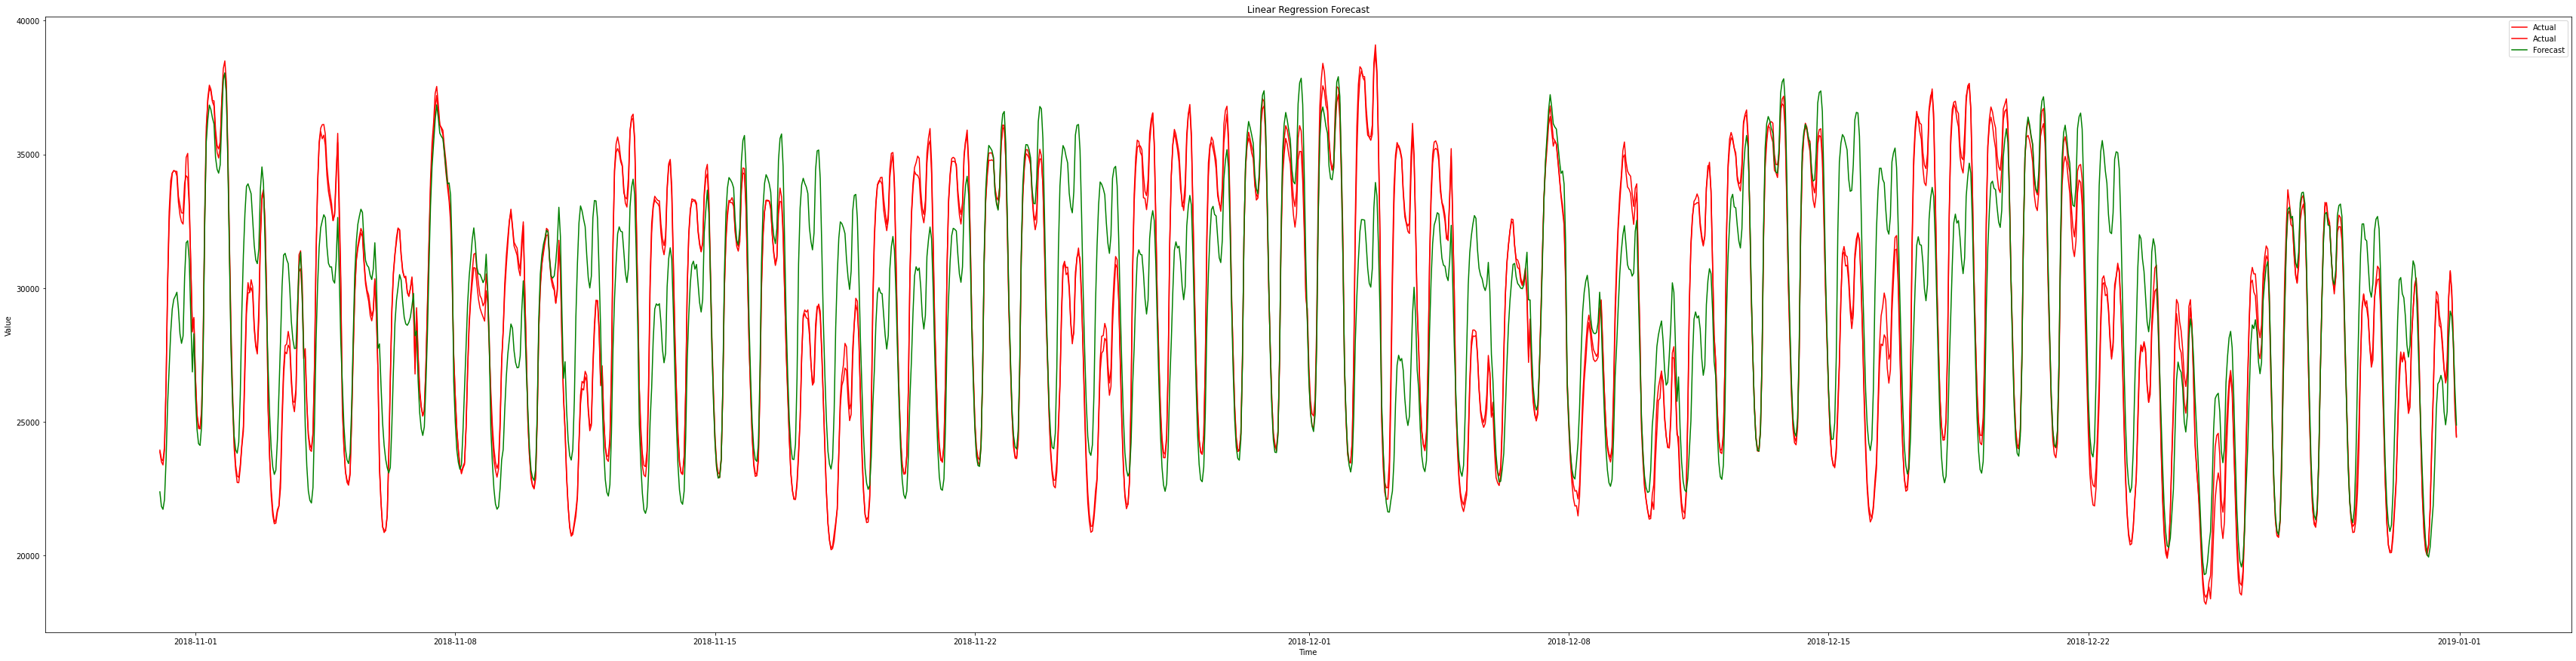

In [ ]:
# Add the seasonal component back to the forecasted values
y_forecast = y_pred + decomposition.seasonal['2018-10-31 01:00:00+00:00':]
# + abs(decomposition.seasonal[-24*40:])
# Plot the actual and forecasted values
fig, ax = plt.subplots(figsize=(60,15))

ax.plot(imputed_data['2018-10-31 01:00:00+00:00':].index, imputed_data['2018-10-31 01:00:00+00:00':].values, color = 'red', label='Actual')
ax.plot(imputed_data['2018-10-31 01:00:00+00:00':].index, y_forecast, color = 'green', label='Forecast')
ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.set_title('Linear Regression Forecast')
ax.legend()
plt.show()

#### Model Evaluation

In [ ]:
#function that outputs the MSE, RMSE and MAE 
def perf_m (r,d, word=''):
  print(word)
  # Calculate MSE
  mse = mean_squared_error(r, d)
  print("MSE:", mse)

  # Calculate RMSE
  rmse = np.sqrt(mse)
  print("RMSE:", rmse)

  # Calculate MAE
  mae = mean_absolute_error(r, d)
  print("MAE:", mae,'\n')

In [ ]:
perf_m(imputed_data['2018-10-31 01:00:00+00:00':]['total load actual'].values, y_forecast)

 

MSE: 7648262.229800748
RMSE: 2765.549173274767
MAE: 2090.6162377576693


In [ ]:
perf_m(imputed_data['2018-10-31 01:00:00+00:00':]['total load actual'].values, imputed_data['2018-10-31 01:00:00+00:00':]['total load forecast'].values)

 

MSE: 123665.99461641992
RMSE: 351.6617616637042
MAE: 257.27187079407804


### LSTM & Decomposition

In [246]:
# scale the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(pd.DataFrame(deseasonalized))
scaled_data

array([[0.49357815],
       [0.51952346],
       [0.51116017],
       ...,
       [0.47125383],
       [0.45022733],
       [0.45250487]])

In [247]:
#split into train and test data
train = scaled_data[:33578]
test = scaled_data[33578:]

We want to know the load for every 6 hours

In [ ]:
# define generator
n_input = 6
n_features = 1
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=1)

In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(10, input_shape=(6, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(generator, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
33572/33572 - 142s - loss: 0.0011 - 142s/epoch - 4ms/step
Epoch 2/10
33572/33572 - 135s - loss: 4.2603e-04 - 135s/epoch - 4ms/step
Epoch 3/10
33572/33572 - 131s - loss: 4.1522e-04 - 131s/epoch - 4ms/step
Epoch 4/10
33572/33572 - 135s - loss: 4.1342e-04 - 135s/epoch - 4ms/step
Epoch 5/10
33572/33572 - 139s - loss: 4.0742e-04 - 139s/epoch - 4ms/step
Epoch 6/10
33572/33572 - 141s - loss: 4.0365e-04 - 141s/epoch - 4ms/step
Epoch 7/10
33572/33572 - 142s - loss: 4.0301e-04 - 142s/epoch - 4ms/step
Epoch 8/10
33572/33572 - 138s - loss: 3.9769e-04 - 138s/epoch - 4ms/step
Epoch 9/10
33572/33572 - 138s - loss: 3.9821e-04 - 138s/epoch - 4ms/step
Epoch 10/10
33572/33572 - 137s - loss: 3.9561e-04 - 137s/epoch - 4ms/step


In [283]:
#genarator for test data
n_input = 6
n_features = 1
test_generator = TimeseriesGenerator(test, test, length=n_input, batch_size=1)

In [284]:
#predict for test data and inverse transform it
lstm_pred = scaler.inverse_transform(model.predict_generator(test_generator))

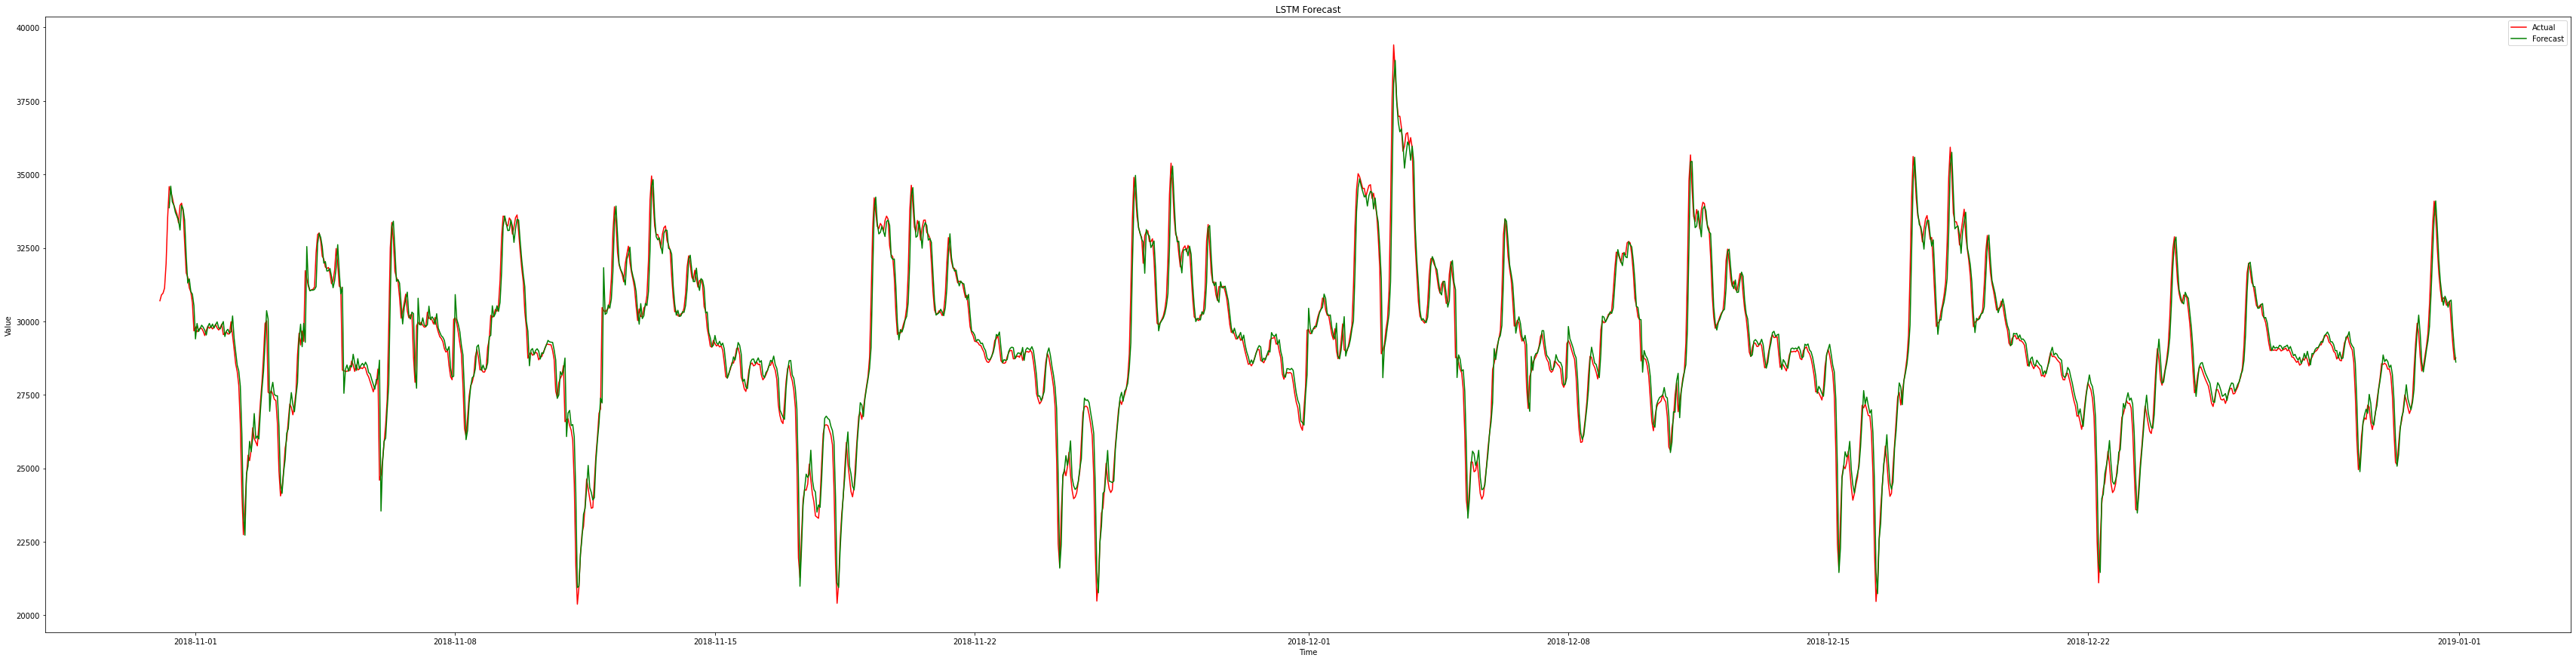

In [266]:
# Plot the actual and forecasted values
fig, ax = plt.subplots(figsize=(60,15))
ax.plot(imputed_data[33578:].index, scaler.inverse_transform(test), color = 'red', label='Actual')
ax.plot(imputed_data[33584:].index, lstm_pred, color = 'green', label='Forecast')
ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.set_title('LSTM Forecast')
ax.legend()
plt.show()

In [285]:
lstm_pred = pd.DataFrame(list(lstm_pred))
lstm_pred = lstm_pred.rename(columns = {0:'Pred'})
lstm_pred

,Pred
0,33865.066406
1,34600.175781
2,34066.355469
3,33954.101562
4,33704.222656
...,...
1475,30681.009766
1476,30722.857422
1477,29776.937500
1478,29086.173828


In [287]:
lstm_pred = lstm_pred.set_index(decomposition.seasonal[33584:].index)
lstm_pred

,Pred
time,
2018-10-31 07:00:00+00:00,33865.066406
2018-10-31 08:00:00+00:00,34600.175781
2018-10-31 09:00:00+00:00,34066.355469
2018-10-31 10:00:00+00:00,33954.101562
2018-10-31 11:00:00+00:00,33704.222656
...,...
2018-12-31 18:00:00+00:00,30681.009766
2018-12-31 19:00:00+00:00,30722.857422
2018-12-31 20:00:00+00:00,29776.937500


In [290]:
# Add the seasonal component back to the forecasted values
lstm_forecast = lstm_pred.Pred + pd.DataFrame(decomposition.seasonal[33584:]).seasonal
lstm_forecast

time
2018-10-31 07:00:00+00:00    31733.603294
2018-10-31 08:00:00+00:00    33792.689781
2018-10-31 09:00:00+00:00    34141.455732
2018-10-31 10:00:00+00:00    34393.301483
2018-10-31 11:00:00+00:00    34265.406367
                                 ...     
2018-12-31 18:00:00+00:00    30643.755406
2018-12-31 19:00:00+00:00    30476.839573
2018-12-31 20:00:00+00:00    28587.857189
2018-12-31 21:00:00+00:00    26190.712619
2018-12-31 22:00:00+00:00    24312.486819
Length: 1480, dtype: float64

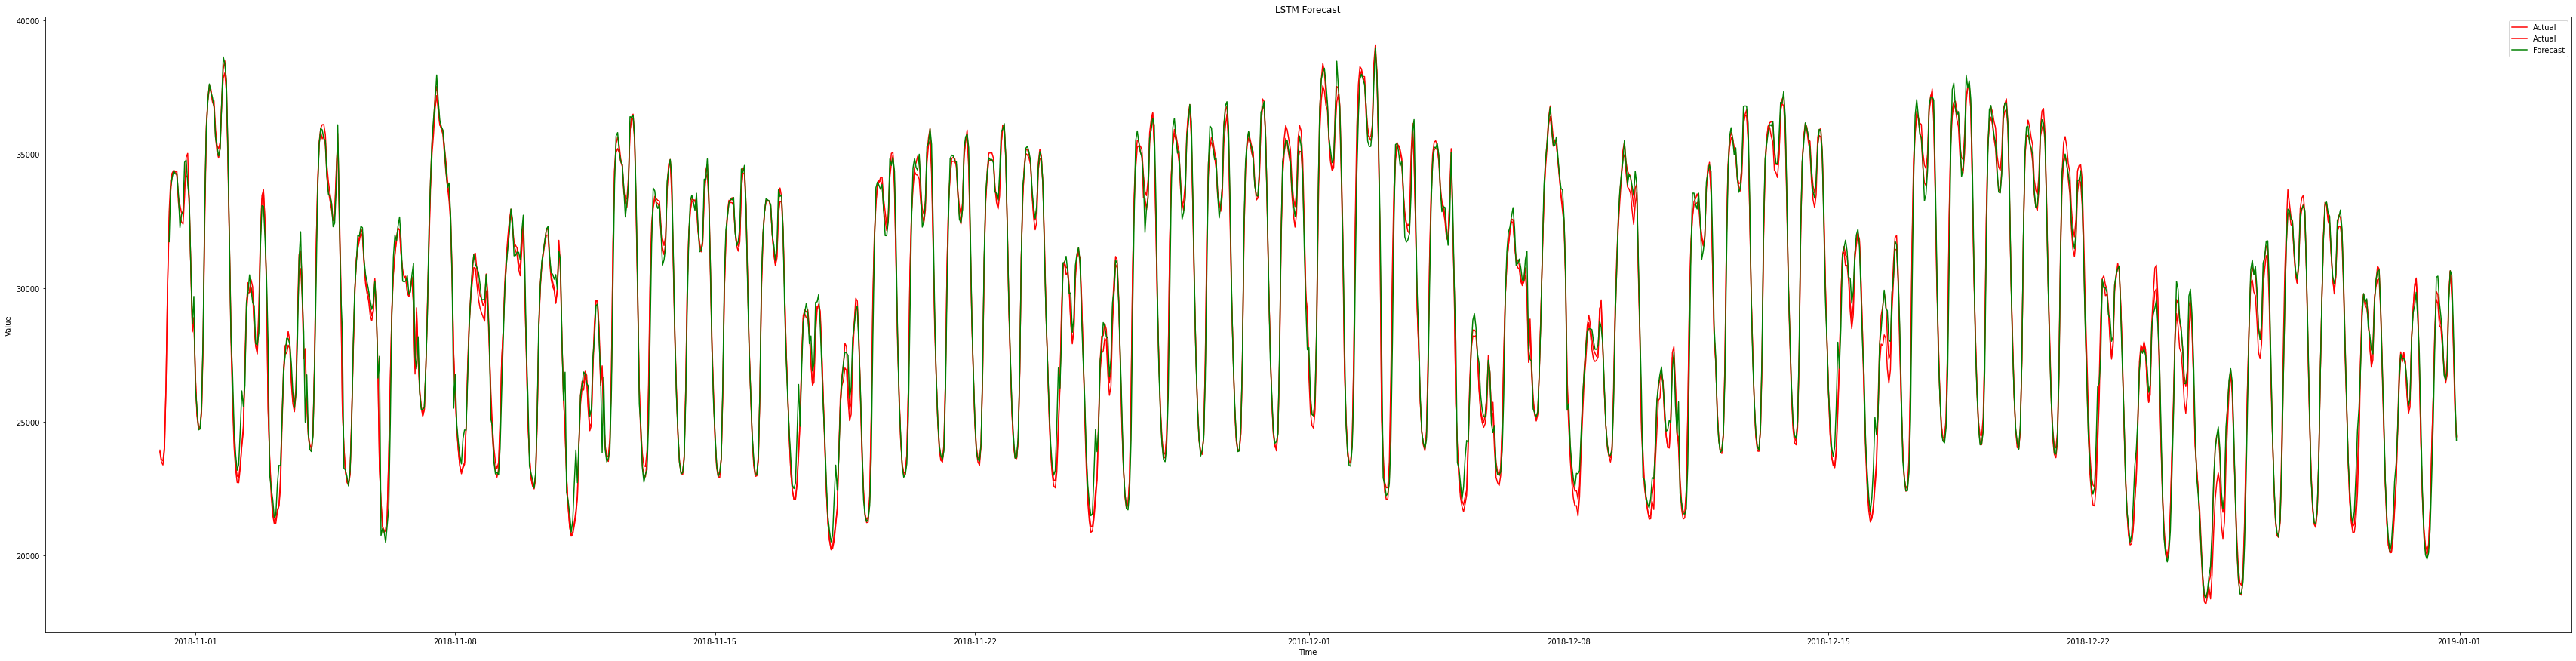

In [292]:
# Plot the actual and forecasted values
fig, ax = plt.subplots(figsize=(60,15))
ax.plot(imputed_data[33578:].index, imputed_data[33578:].values, color = 'red', label='Actual')
ax.plot(imputed_data[33584:].index, lstm_forecast, color = 'green', label='Forecast')
ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.set_title('LSTM Forecast')
ax.legend()
plt.show()

In [309]:
print(perf_m(imputed_data[33584:]['total load actual'], lstm_forecast, "LSTM with Decomposition "))

LSTM with Decomposition 
MSE: 301049.83830822696
RMSE: 548.680087399048
MAE: 349.37802619866335 

None


In [310]:
perf_m(imputed_data['2018-10-31 01:00:00+00:00':]['total load actual'].values, imputed_data['2018-10-31 01:00:00+00:00':]['total load forecast'].values, "Best Model")

Best Model
MSE: 123665.99461641992
RMSE: 351.6617616637042
MAE: 257.27187079407804 



### LSTM

In [302]:
# scale the dataset
scaler_lstm = MinMaxScaler(feature_range=(0, 1))
scaled_data_lstm = scaler_lstm.fit_transform(pd.DataFrame(imputed_data['total load actual']))
scaled_data_lstm

array([[0.31966571],
       [0.27600766],
       [0.2042744 ],
       ...,
       [0.43658048],
       [0.33777313],
       [0.27918517]])

In [303]:
#split into train and test data
s_train = scaled_data_lstm[:33578]
s_test = scaled_data_lstm[33578:]

In [307]:
# define generator
n_input = 6
n_features = 1
lstm_train_generator = TimeseriesGenerator(s_train, s_train, length=n_input, batch_size=1)

In [308]:
# create and fit the LSTM network
model2 = Sequential()
model2.add(LSTM(10, input_shape=(6, 1)))
model2.add(Dense(1))
model2.compile(loss='mean_squared_error', optimizer='adam')
model2.fit(lstm_train_generator, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
33572/33572 - 174s - loss: 0.0031 - 174s/epoch - 5ms/step
Epoch 2/10
33572/33572 - 141s - loss: 0.0016 - 141s/epoch - 4ms/step
Epoch 3/10
33572/33572 - 145s - loss: 0.0015 - 145s/epoch - 4ms/step
Epoch 4/10
33572/33572 - 142s - loss: 0.0014 - 142s/epoch - 4ms/step
Epoch 5/10
33572/33572 - 138s - loss: 0.0013 - 138s/epoch - 4ms/step
Epoch 6/10
33572/33572 - 140s - loss: 0.0013 - 140s/epoch - 4ms/step
Epoch 7/10
33572/33572 - 137s - loss: 0.0012 - 137s/epoch - 4ms/step
Epoch 8/10
33572/33572 - 139s - loss: 0.0012 - 139s/epoch - 4ms/step
Epoch 9/10
33572/33572 - 138s - loss: 0.0012 - 138s/epoch - 4ms/step
Epoch 10/10
33572/33572 - 140s - loss: 0.0012 - 140s/epoch - 4ms/step


In [316]:
#genarator for test data
n_input = 6
n_features = 1
lstm_test_generator = TimeseriesGenerator(s_test, s_test, length=n_input, batch_size=1)

In [317]:
#predict for test data and inverse transform it
lstm_test_pred = scaler_lstm.inverse_transform(model2.predict_generator(lstm_test_generator))

In [318]:
lstm_test_pred = pd.DataFrame(list(lstm_test_pred))
lstm_test_pred = lstm_test_pred.rename(columns = {0:'Pred'})
lstm_test_pred

,Pred
0,32352.087891
1,33622.363281
2,34184.640625
3,34588.433594
4,34260.597656
...,...
1475,32114.582031
1476,30123.318359
1477,28725.228516
1478,26147.435547


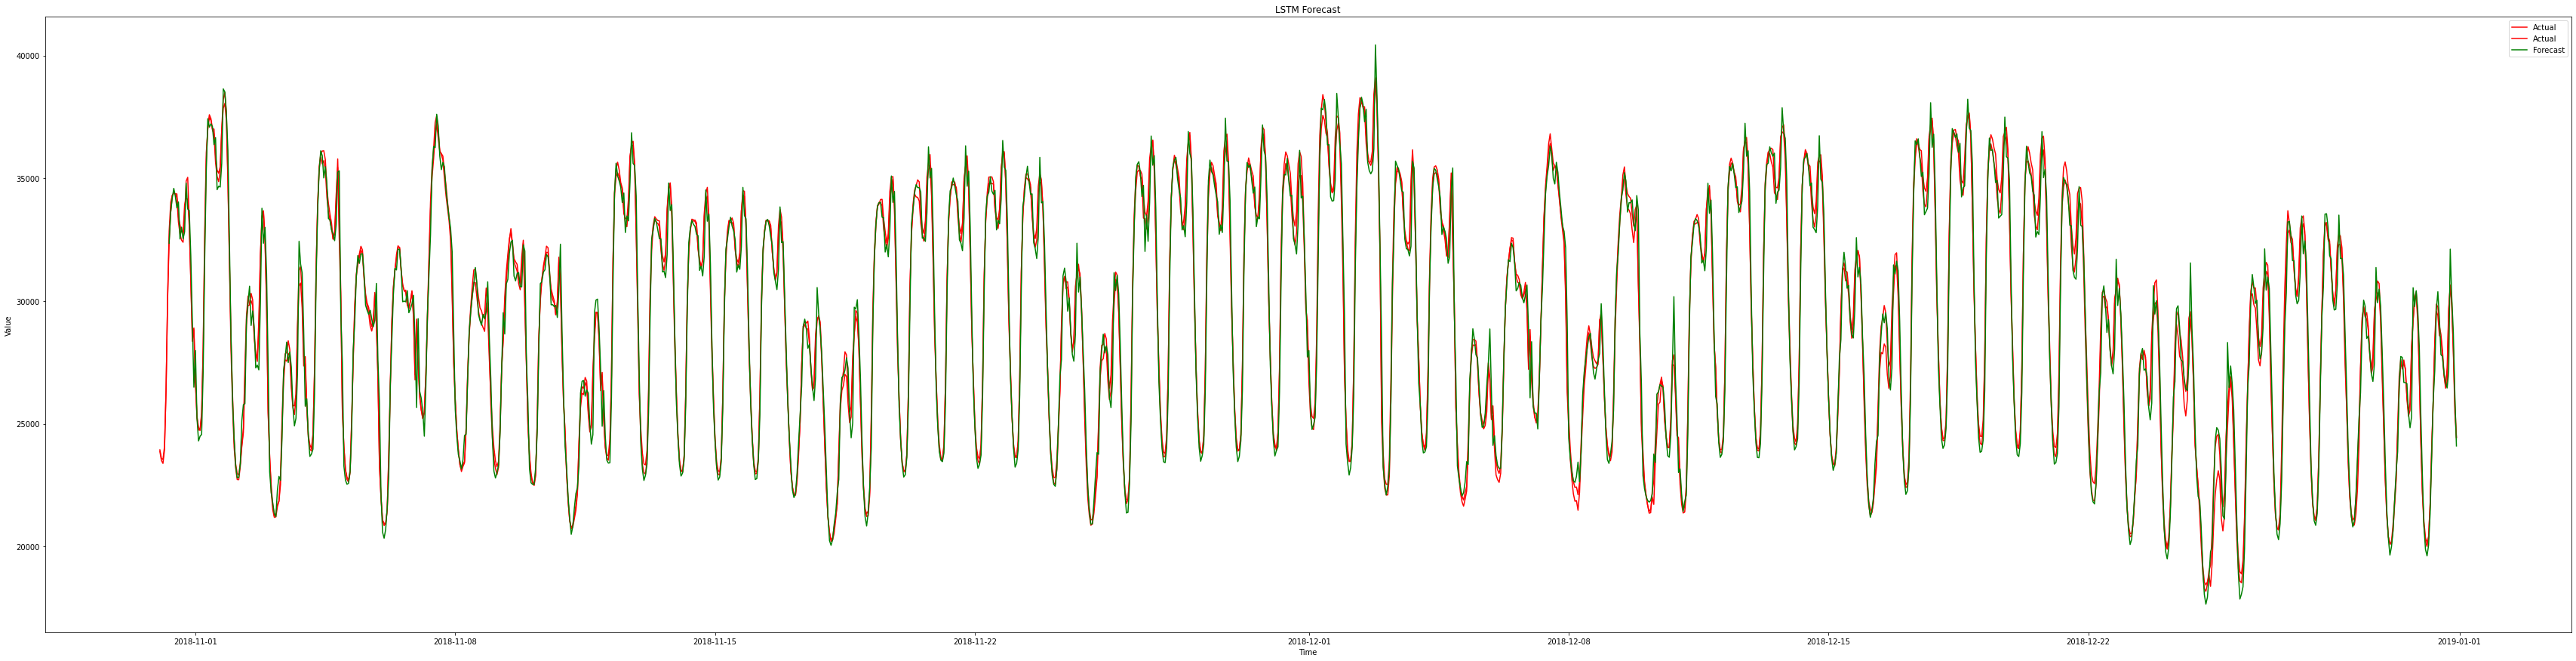

In [319]:
# Plot the actual and forecasted values
fig, ax = plt.subplots(figsize=(60,15))
ax.plot(imputed_data[33578:].index, imputed_data[33578:].values, color = 'red', label='Actual')
ax.plot(imputed_data[33584:].index, lstm_test_pred, color = 'green', label='Forecast')
ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.set_title('LSTM Forecast')
ax.legend()
plt.show()

In [320]:
print(perf_m(imputed_data[33584:]['total load actual'], lstm_test_pred, "LSTM "))

LSTM 
MSE: 495145.2590802064
RMSE: 703.6655875344526
MAE: 516.5887009079391 

None


In [321]:
perf_m(imputed_data['2018-10-31 01:00:00+00:00':]['total load actual'].values, imputed_data['2018-10-31 01:00:00+00:00':]['total load forecast'].values, "Best Model")

Best Model
MSE: 123665.99461641992
RMSE: 351.6617616637042
MAE: 257.27187079407804 

